In [83]:
# 1. Initial Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, SelectKBest, f_classif, mutual_info_classif
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

# Install mlxtend if needed
try:
    from mlxtend.feature_selection import SequentialFeatureSelector as SFS
except ModuleNotFoundError:
    !pip install mlxtend
    from mlxtend.feature_selection import SequentialFeatureSelector as SFS


In [84]:
# %% [code] - Data Preprocessing
# Load original data
original_df = pd.read_excel(r'C:\Project\livertransplant\datasets\GRWR _0.8.xlsx', sheet_name='Sheet1')

# Print EXACT column names with hidden characters
print("Original Columns (Exact Names):")
print([repr(col) for col in original_df.columns])

# Create working copy with renamed column
working_df = original_df.copy(deep=True)

# Define column names
exact_long_col = 'Primary diagnosis:  Ethanol =0; NASH = 1; HBV = 2, HCV = 3, AIH = 4, PSC/Overlap = 5, Wilsons = 6, Hemochromatosis = 7; cryptogenic = 8; BCS = 9; PBC - 10;  Fibrolamellar HCC = 11; Primary hyperoxaluria = 12; Metabolic liver disease = 13, BA = 14, PFIC = 15; HHT = 16; DILI = 17; SBC = 18; yellow phosporous = 19; HEH - 20 ; NCPF = 21; CHF = 22; HEV = 23; HAV = 24; Hepatoblastoma = 25; PCKLD = 26; Alagille = 27, Epidermolysis bullosa = 28; pregnancy related = 29; SLE related = 30; Multiple hepatic adenomas = 31'


# Create working copy with guaranteed rename
working_df = original_df.copy()
working_df.rename(columns={exact_long_col: 'Diagnosis_Code'}, inplace=True)

# Validate rename
assert 'Diagnosis_Code' in working_df.columns, "Rename failed! Check exact_long_col"
print("\nWorking Copy Columns:", working_df.columns.tolist())

# Clean columns in working copy
columns_to_drop = [
    'Tx No', 'Name', 'UHID', 'date of surgery',
    'Date of death', 'Additional comments', 'Cause of death',
    'Alive/Dead 0 = 0; D=1', 'Length of hospital stay'
]
working_df = working_df.drop(columns_to_drop, axis=1, errors='ignore')

# Handle missing values
working_df['SFSS Y=1/N=0'] = working_df['SFSS Y=1/N=0'].fillna(0).astype(int)
working_df = working_df.apply(pd.to_numeric, errors='coerce')
working_df = working_df.dropna(axis=1, how='all')
working_df = working_df.fillna(working_df.median())


Original Columns (Exact Names):
["'Tx No'", "'Name'", "'UHID'", "'Age'", "'Gender M = 0; F = 1'", "'Primary diagnosis:  Ethanol =0; NASH = 1; HBV = 2, HCV = 3, AIH = 4, PSC/Overlap = 5, Wilsons = 6, Hemochromatosis = 7; cryptogenic = 8; BCS = 9; PBC - 10;  Fibrolamellar HCC = 11; Primary hyperoxaluria = 12; Metabolic liver disease = 13, BA = 14, PFIC = 15; HHT = 16; DILI = 17; SBC = 18; yellow phosporous = 19; HEH - 20 ; NCPF = 21; CHF = 22; HEV = 23; HAV = 24; Hepatoblastoma = 25; PCKLD = 26; Alagille = 27, Epidermolysis bullosa = 28; pregnancy related = 29; SLE related = 30; Multiple hepatic adenomas = 31'", "'BMI '", "'MELD/PELD'", "'Adult  = 0; ped = 1 '", "'Portal vein thrombosis'", "'Preoperative HCC'", "'date of surgery'", "'Donor Age'", "'Donor Gender M = 0; F=1'", "'Lobe - RL=0, RPS = 1, LL = 2'", "'additional procedures'", "'Graft wt '", "'GRWR'", "'Blood loss'", "'CIT'", "'WIT'", "'Portal velocity'", "'Pre-reperfusion portal pressure'", "'Post- reperfusion portal pressure'",

In [85]:
# %% [code] - Model Training
X = working_df.drop('SFSS Y=1/N=0', axis=1)
y = working_df['SFSS Y=1/N=0']
feature_names = X.columns.tolist()  # Now contains SHORT_COL

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [86]:
# %% [code] - Feature Selection and Visualization
def plot_features(df, title, xlabel='Importance', palette='viridis'):
    plt.figure(figsize=(16, 10))
    sns.barplot(x=xlabel, y='Feature', data=df.head(15), palette=palette)
    plt.title(f'Top 15 Features - {title}', fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.tight_layout()
    plt.show()

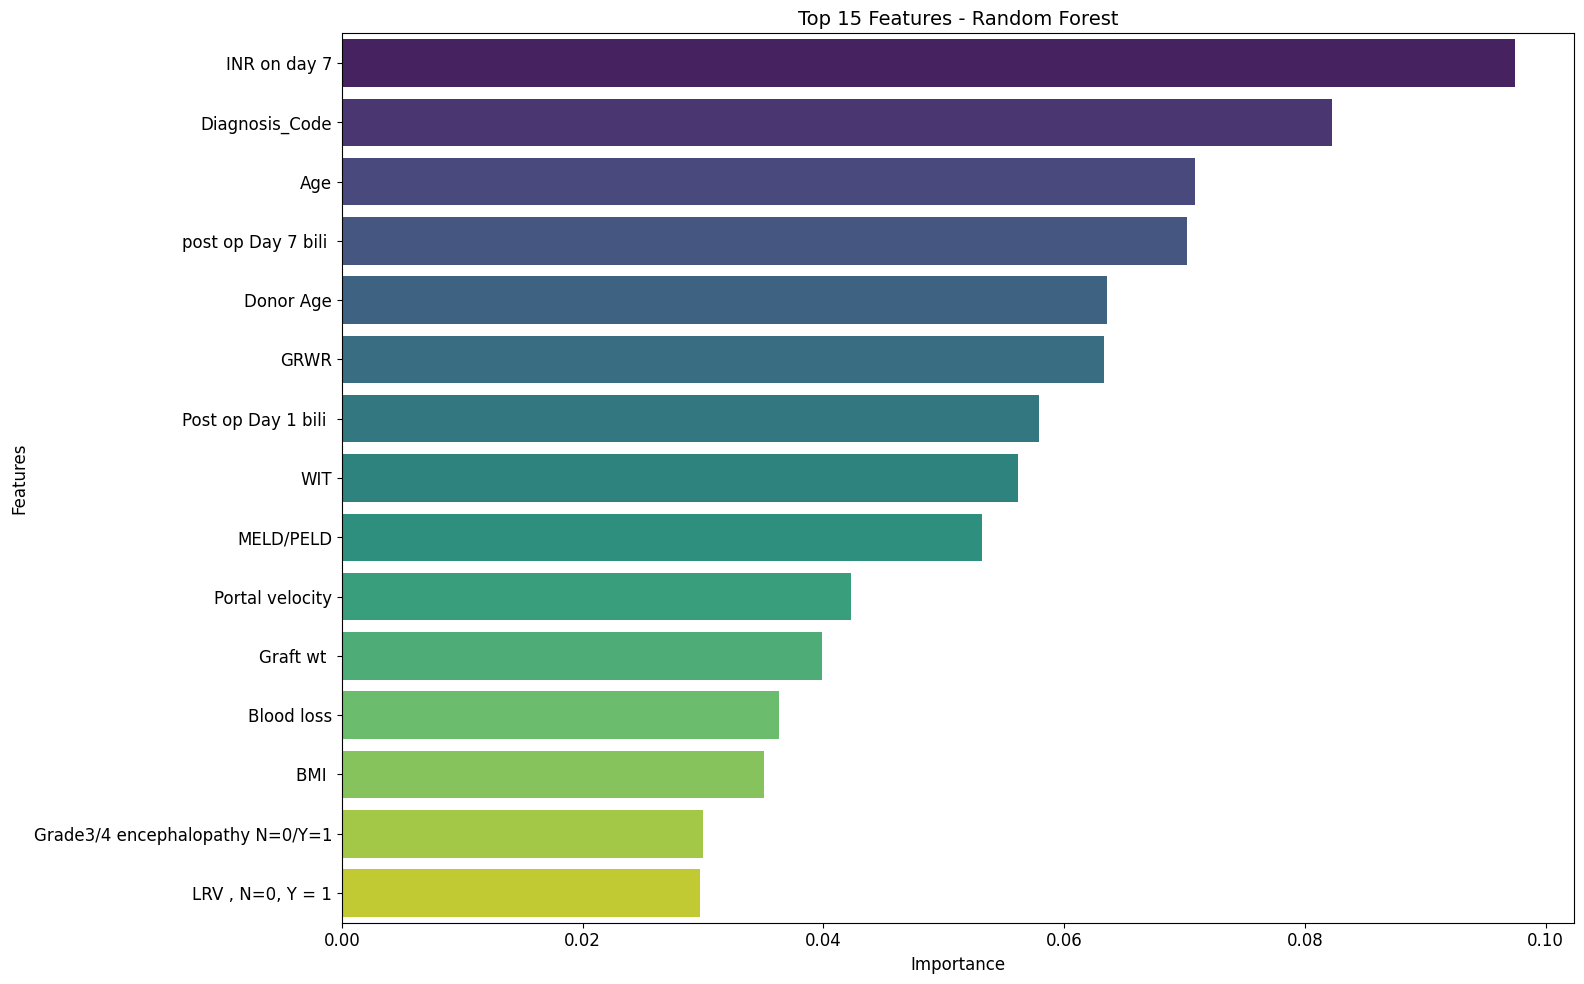

In [87]:
# 1. Random Forest Importance
rf_model = RandomForestClassifier(random_state=42).fit(X_train_scaled, y_train)
rf_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
plot_features(rf_importances, 'Random Forest')

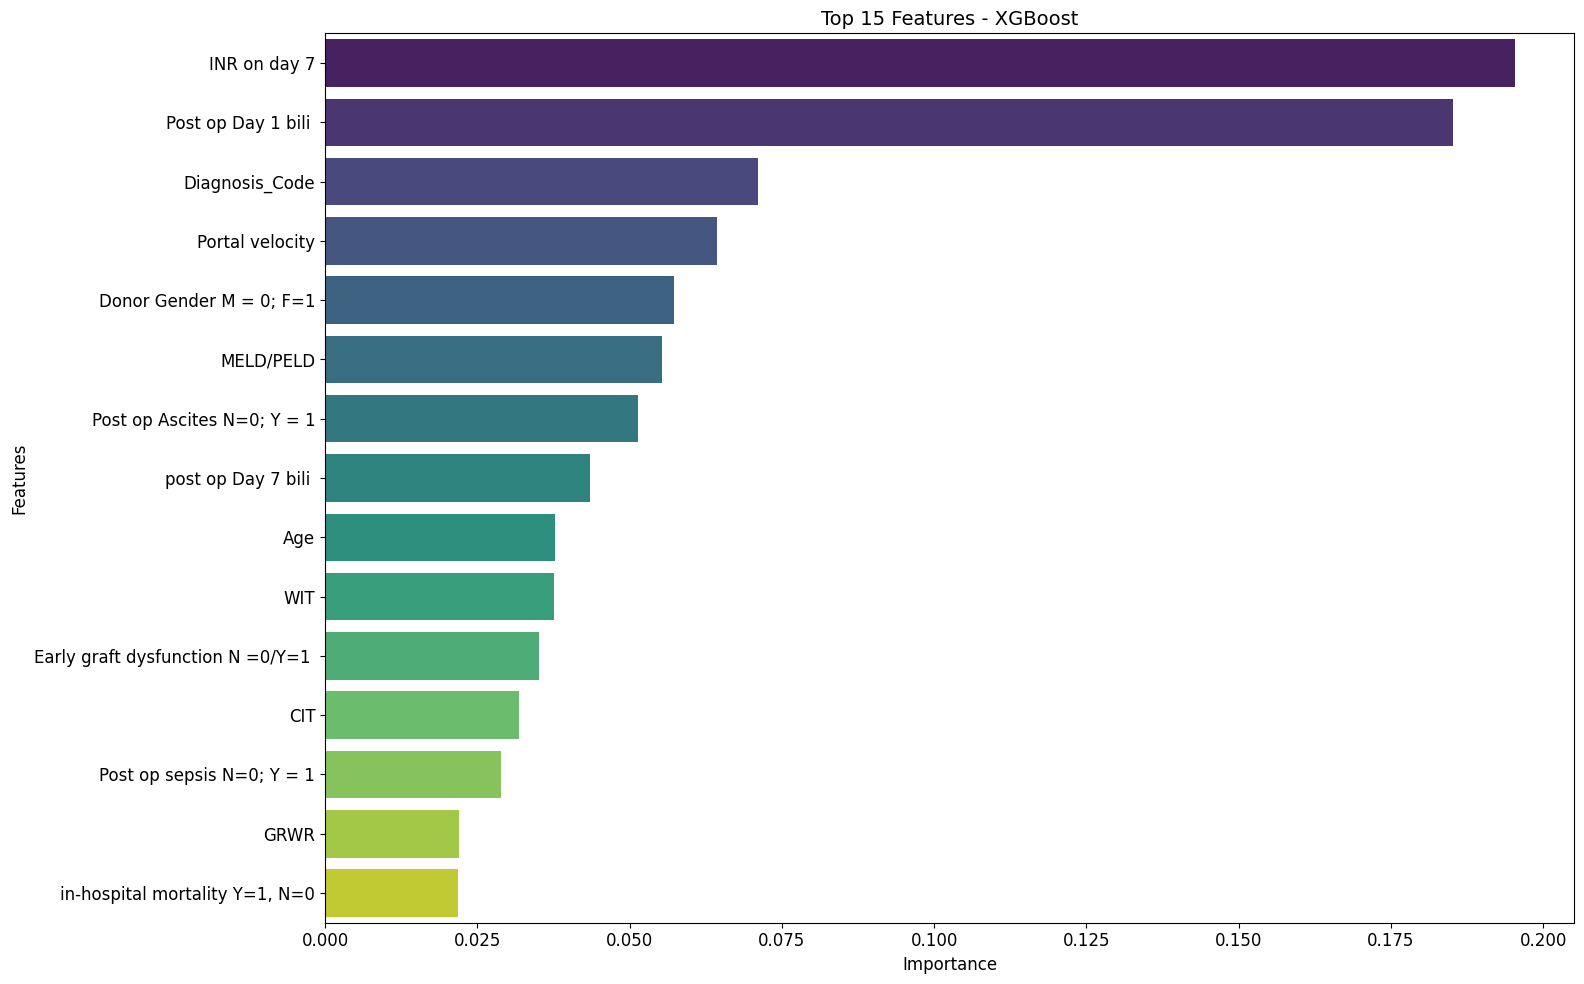

In [88]:
# 2. XGBoost Importance
xgb_model = XGBClassifier(random_state=42).fit(X_train_scaled, y_train)
xgb_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)
plot_features(xgb_importances, 'XGBoost')

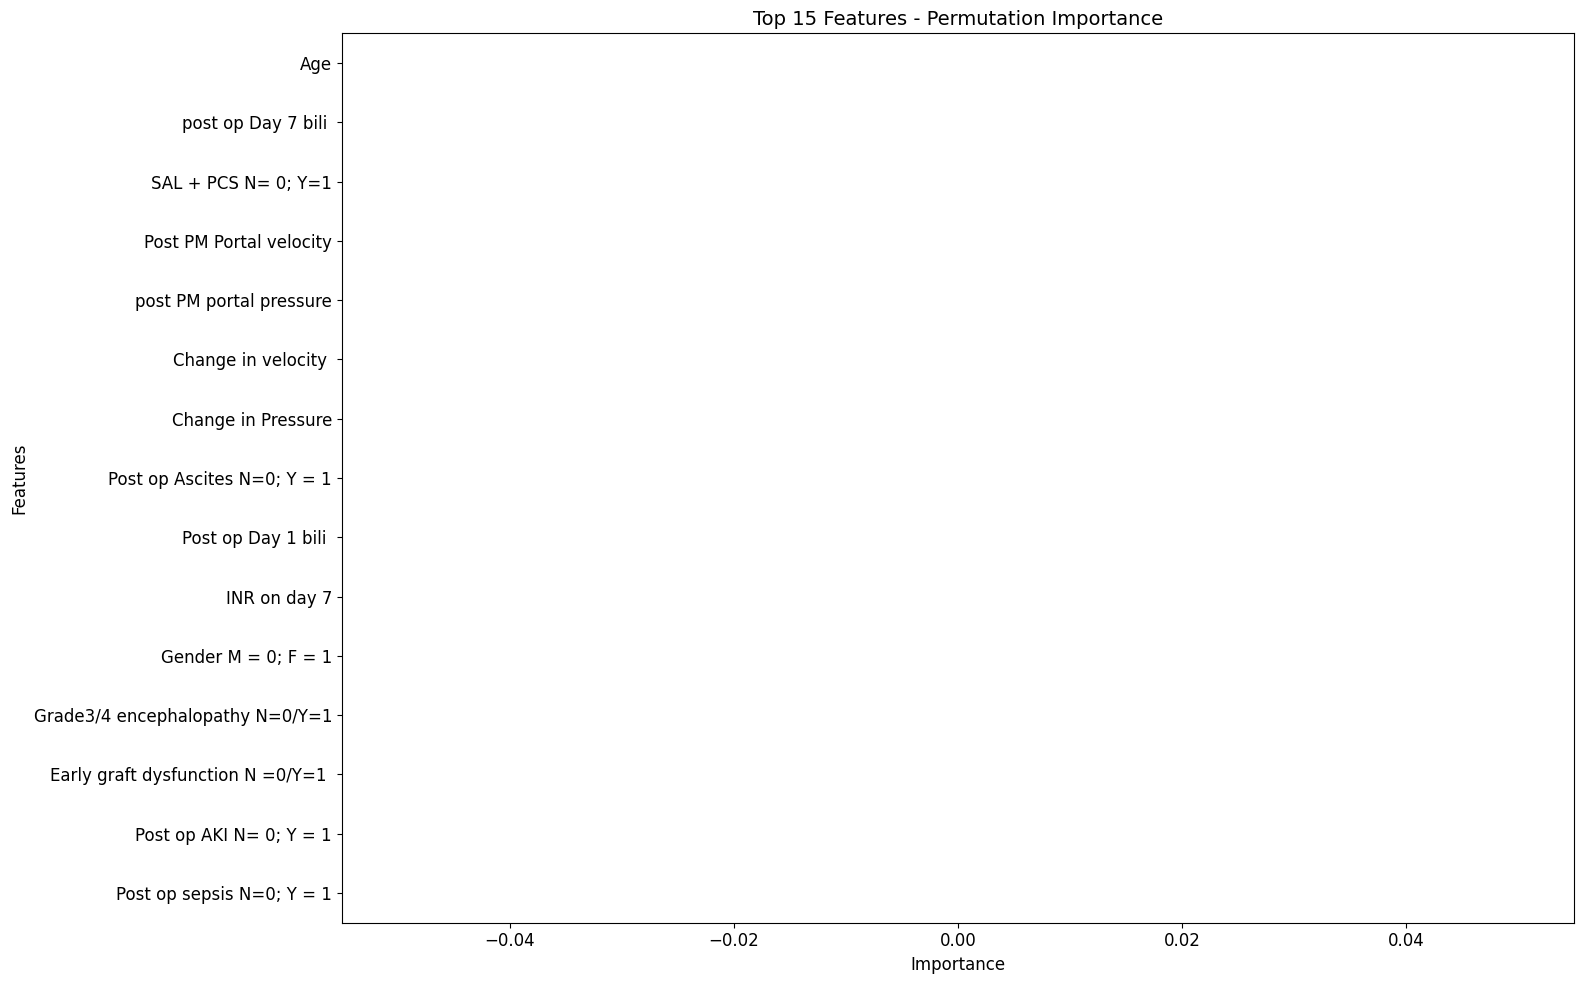

In [89]:
# 3. Permutation Importance
perm_importance = permutation_importance(rf_model, X_test_scaled, y_test, n_repeats=10, random_state=42)
perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)
plot_features(perm_df, 'Permutation Importance', palette='mako')

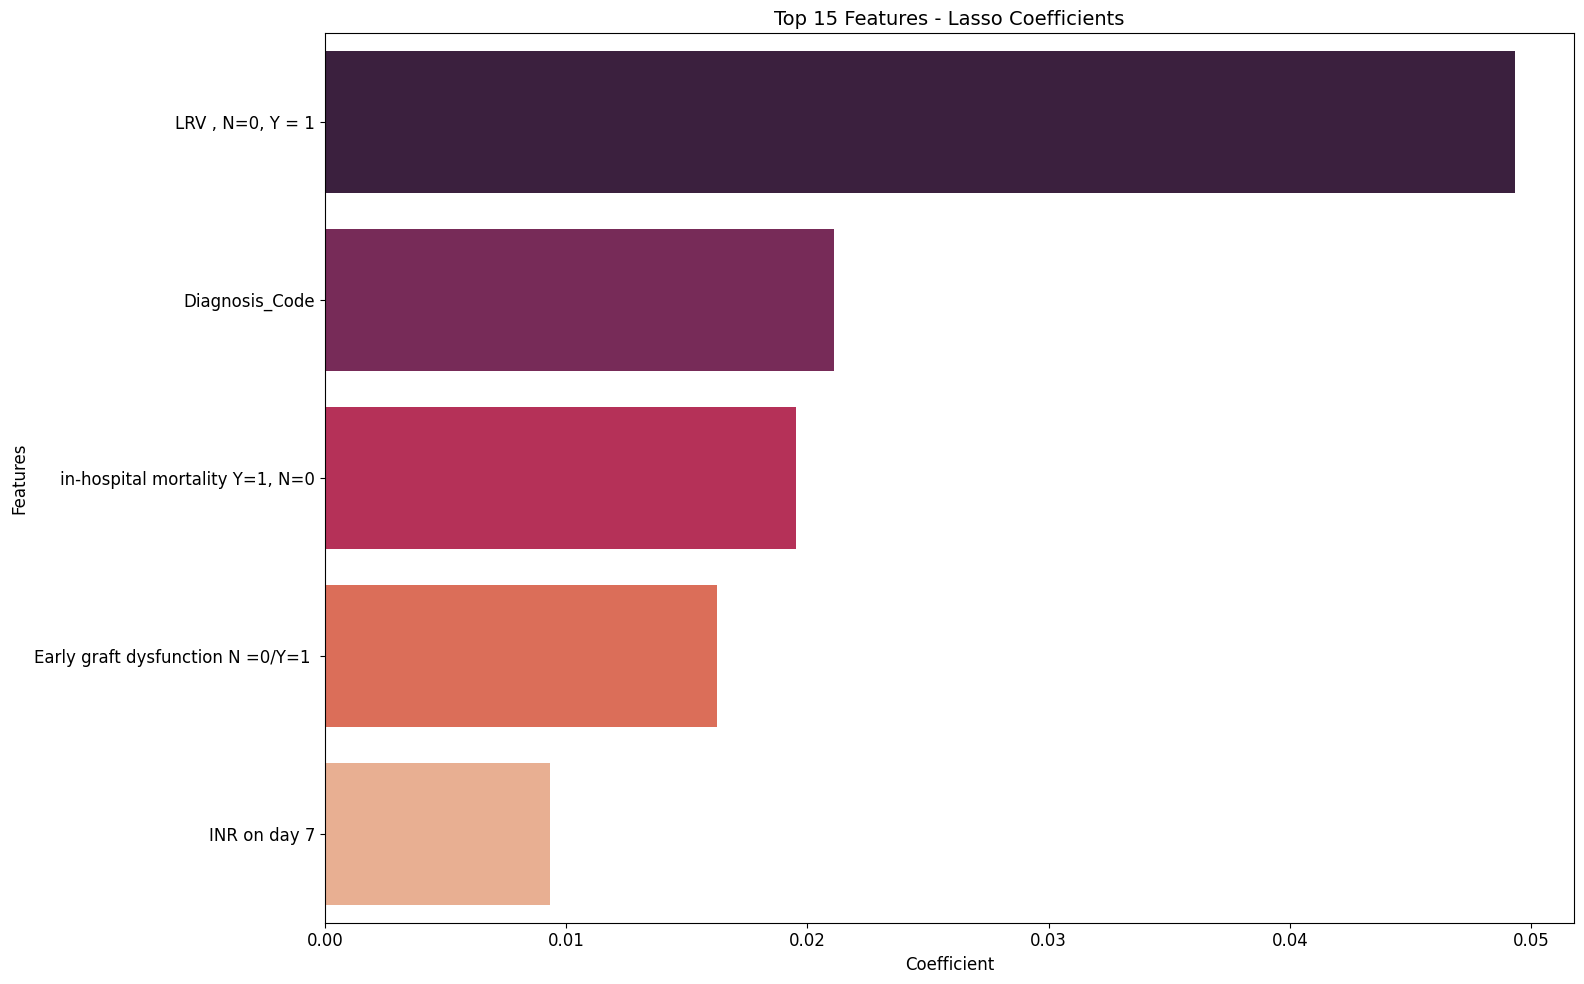

In [90]:
# 4. Lasso Regression
lasso_model = LassoCV(max_iter=10000, random_state=42).fit(X_train_scaled, y_train)
lasso_coef = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_model.coef_
}).query('Coefficient != 0').sort_values('Coefficient', key=abs, ascending=False)
plot_features(lasso_coef, 'Lasso Coefficients', xlabel='Coefficient', palette='rocket')

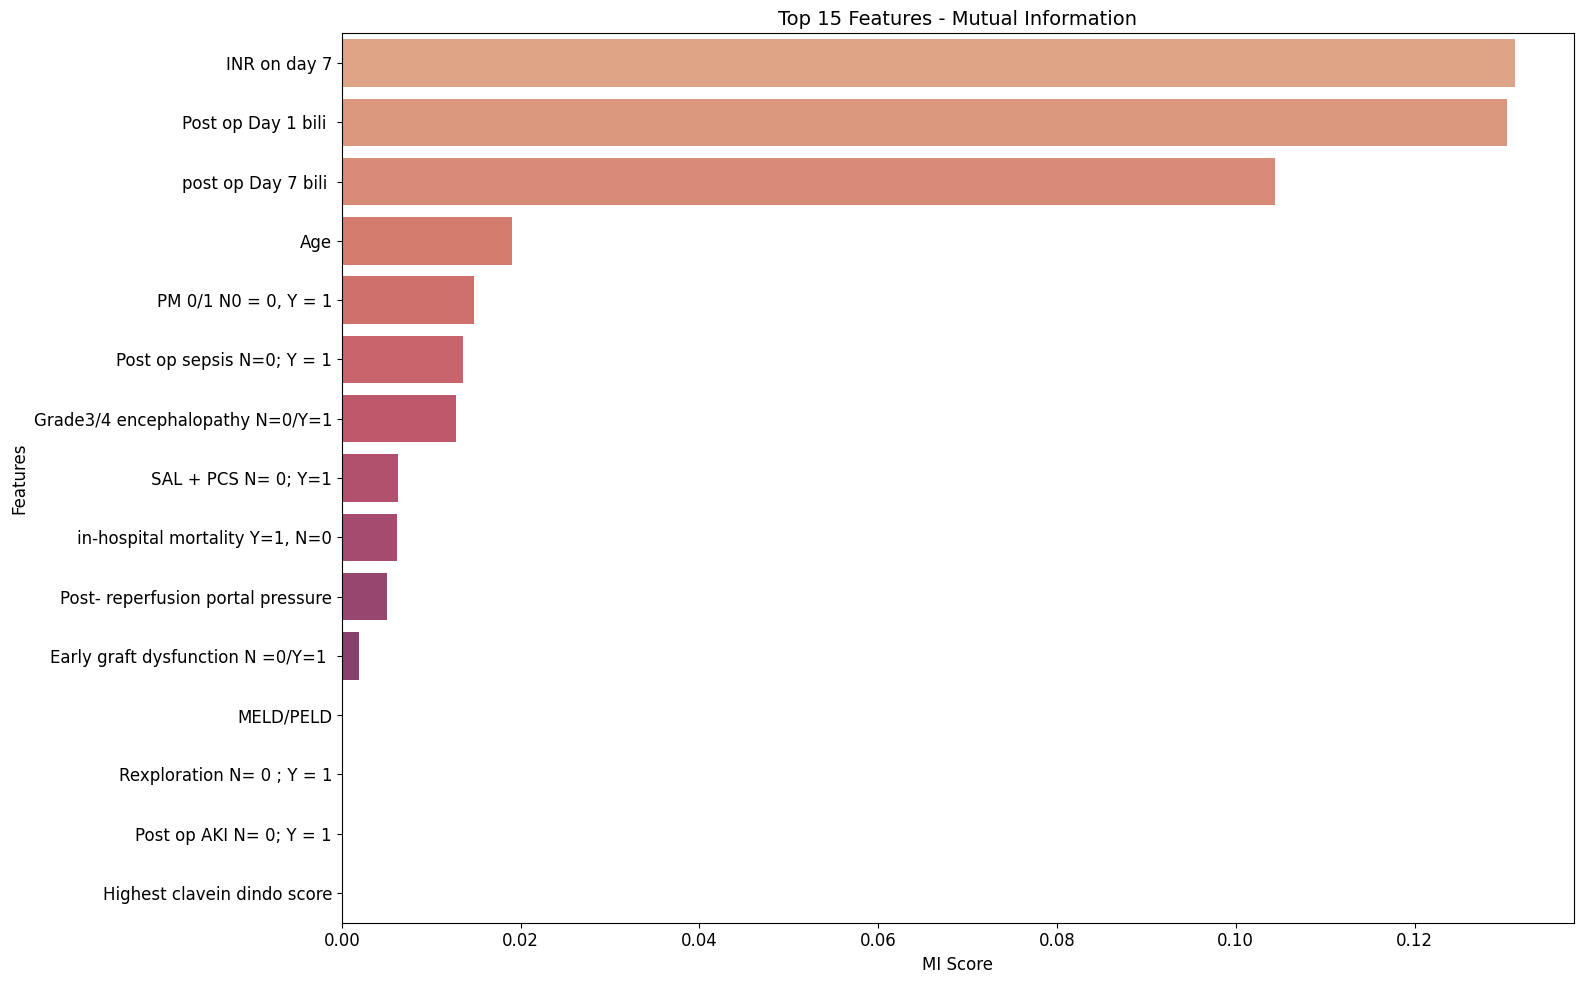

In [92]:
# 5. Mutual Information
mi_scores = mutual_info_classif(X, y, random_state=42)
mi_df = pd.DataFrame({
    'Feature': feature_names,
    'MI Score': mi_scores
}).sort_values('MI Score', ascending=False)
plot_features(mi_df, 'Mutual Information', xlabel='MI Score', palette='flare')

In [93]:
# 6. Sequential Forward Selection
sfs = SFS(RandomForestClassifier(random_state=42),
          k_features=15,
          forward=True,
          cv=5,
          n_jobs=-1).fit(X_train_scaled, y_train)
print("\nSequential Forward Selection Features:")
print(sfs.k_feature_names_)


Sequential Forward Selection Features:
('1', '3', '4', '5', '7', '8', '10', '11', '13', '15', '19', '20', '21', '31', '35')



Model Performance Comparison:


,Model,Accuracy,Precision,Recall,F1,ROC AUC,CV Accuracy (Mean)
0,Logistic Regression,0.879,0.0,0.0,0.000,0.445,0.785
1,Random Forest,0.914,0.0,0.0,0.000,0.909,0.911
2,XGBoost,0.948,1.0,0.4,0.571,0.808,0.881
3,SVM,0.914,0.0,0.0,0.000,0.555,0.911


<Figure size 1400x800 with 0 Axes>

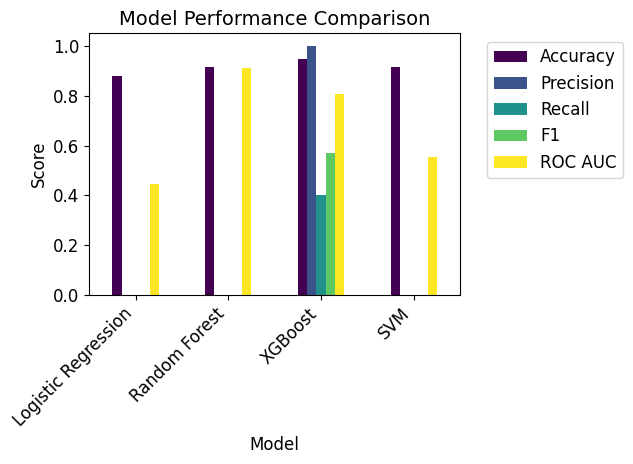

In [94]:
# %% [code] - Model Evaluation & Comparison
models = [
    ('Logistic Regression', LogisticRegression(random_state=42)),
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('SVM', SVC(probability=True, random_state=42))
]

results = []

for name, model in models:
    # Train and predict
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None
    
    # Calculate metrics
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else None,
        'CV Accuracy (Mean)': np.mean(cross_val_score(model, X_train_scaled, y_train, cv=StratifiedKFold(5), scoring='accuracy'))
    }
    results.append(metrics)

# Create comparison dataframe
results_df = pd.DataFrame(results).round(3)

# Display results
print("\nModel Performance Comparison:")
display(results_df)

# Visualization
plt.figure(figsize=(14, 8))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC']
results_df.set_index('Model')[metrics_to_plot].plot(kind='bar', colormap='viridis')
plt.title('Model Performance Comparison', fontsize=14)
plt.ylabel('Score', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

Class Distribution:
 SFSS Y=1/N=0
0    0.911917
1    0.088083
Name: proportion, dtype: float64


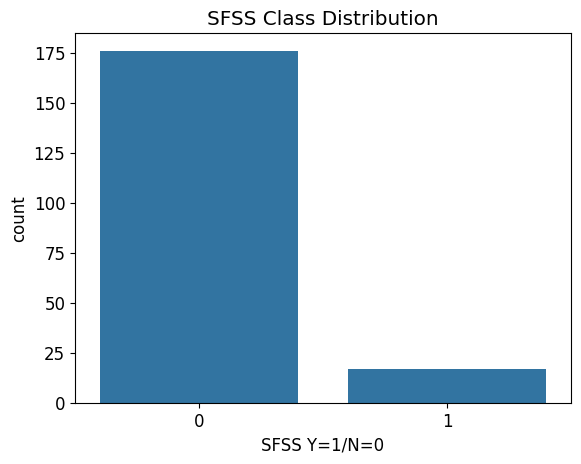

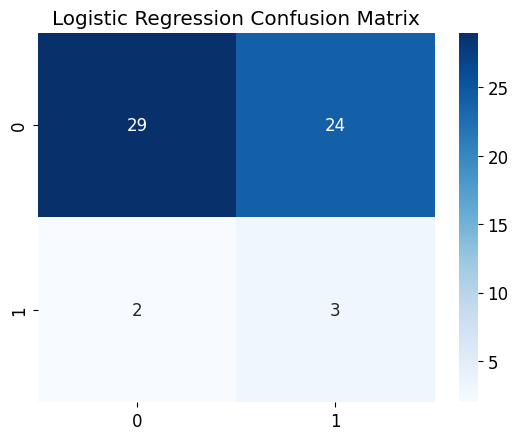

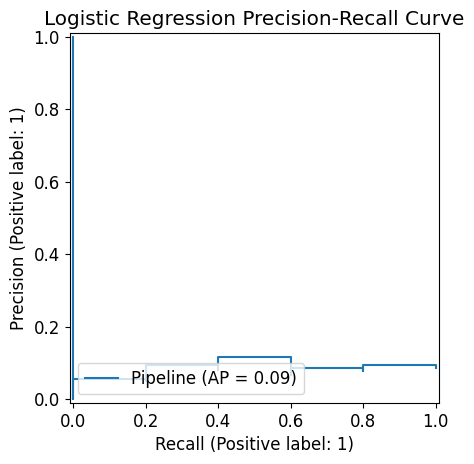

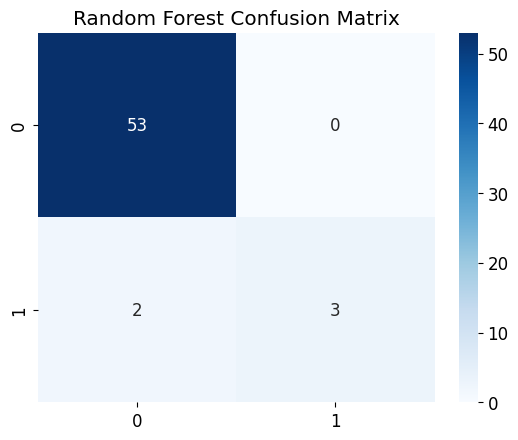

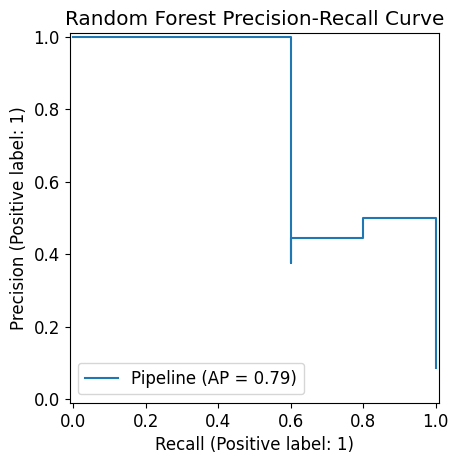

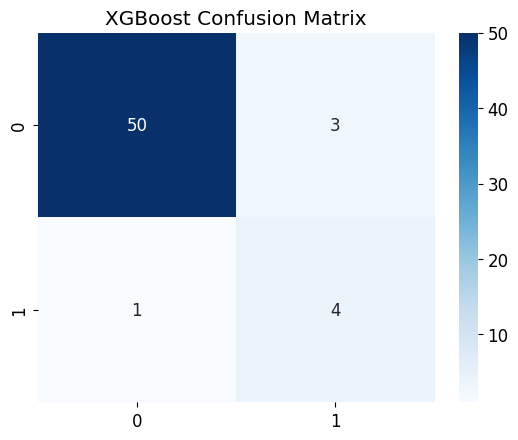

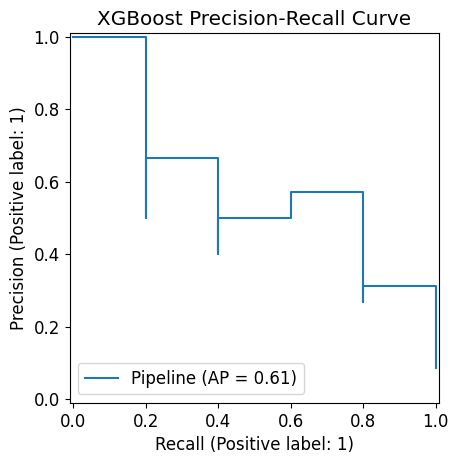

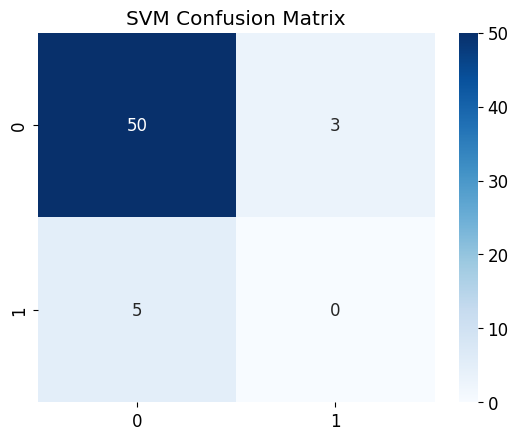

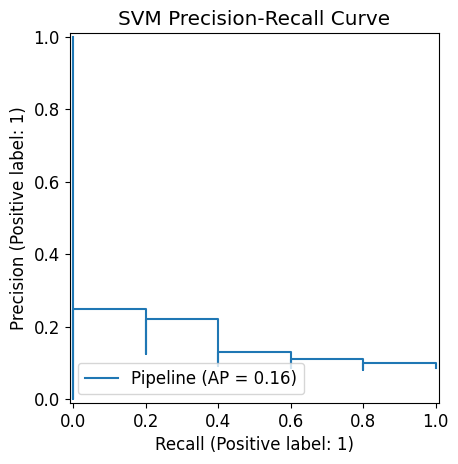

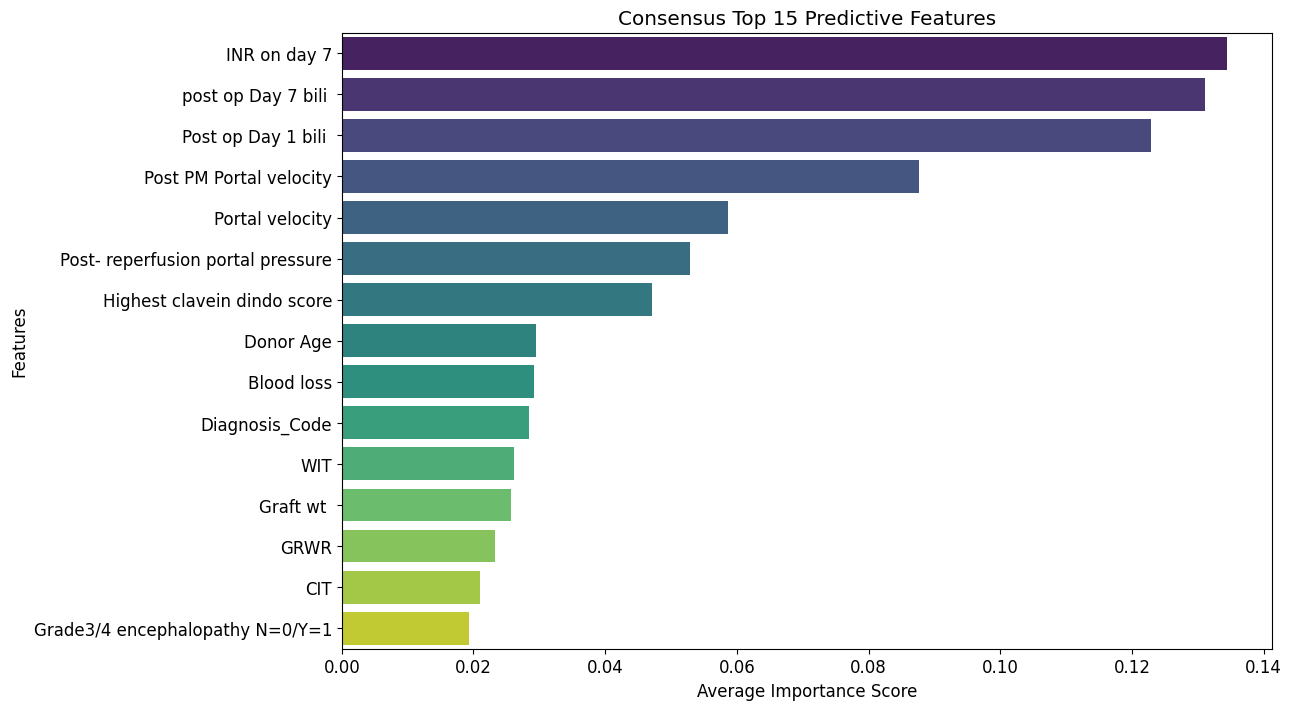

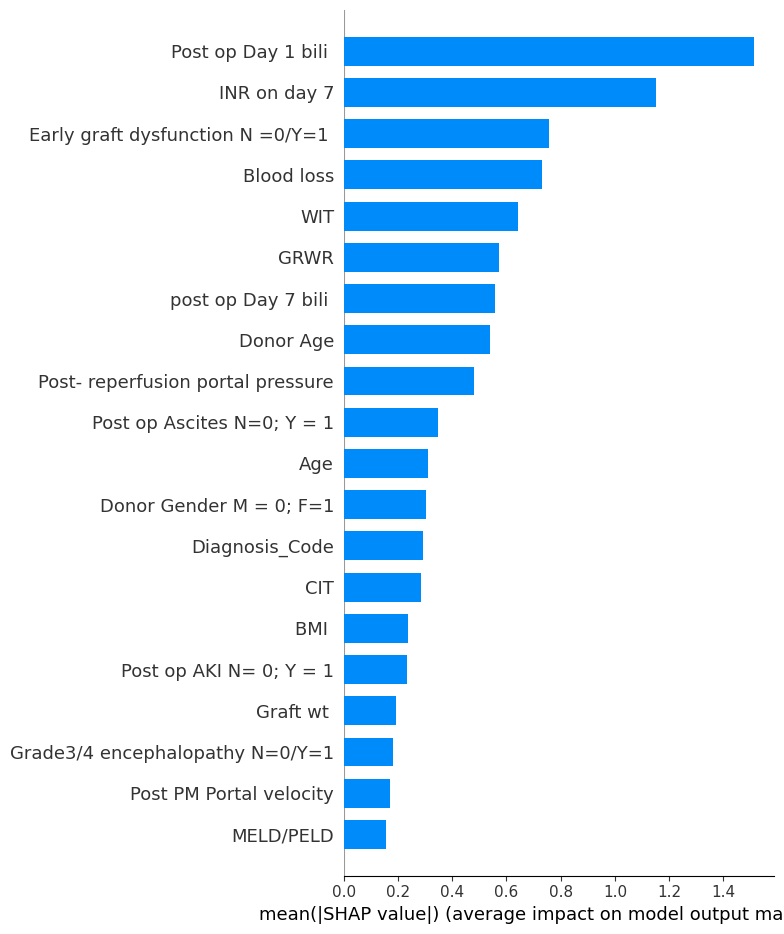

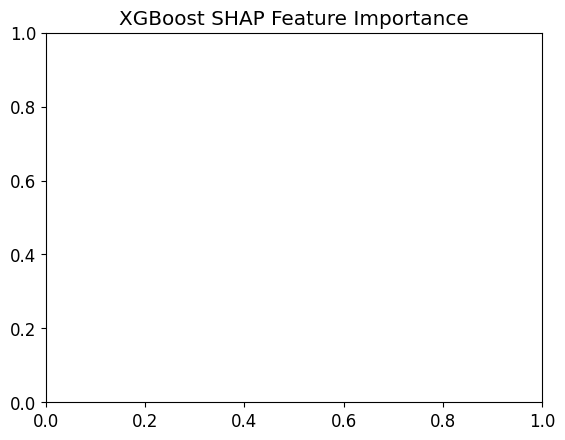

In [95]:
# %% [code] - Class Balance Analysis and Imbalance Handling
# Check class distribution
print("Class Distribution:\n", y.value_counts(normalize=True))
sns.countplot(x=y)
plt.title('SFSS Class Distribution')
plt.show()

# Apply SMOTE for oversampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# %% [code] - Enhanced Model Training with Class Weights
# Updated models with class weights and balanced parameters
models = [
    ('Logistic Regression', LogisticRegression(class_weight='balanced', random_state=42)),
    ('Random Forest', RandomForestClassifier(class_weight='balanced', random_state=42)),
    ('XGBoost', XGBClassifier(scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]), 
                             eval_metric='logloss', random_state=42)),
    ('SVM', SVC(class_weight='balanced', probability=True, random_state=42))
]

# %% [code] - Threshold Optimization Function
def optimize_threshold(model, X_test, y_test):
    y_proba = model.predict_proba(X_test)[:, 1]
    thresholds = np.linspace(0.1, 0.9, 50)
    best_f1 = 0
    best_thresh = 0.5
    
    for thresh in thresholds:
        y_pred = (y_proba >= thresh).astype(int)
        f1 = f1_score(y_test, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thresh
            
    return best_thresh

# %% [code] - Enhanced Model Evaluation
from sklearn.metrics import confusion_matrix, PrecisionRecallDisplay

results = []
feature_importances = []

for name, model in models:
    # Create pipeline with SMOTE
    pipeline = make_pipeline(smote, model)
    pipeline.fit(X_train_scaled, y_train)
    
    # Threshold optimization
    best_thresh = optimize_threshold(pipeline, X_test_scaled, y_test)
    y_proba = pipeline.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_proba >= best_thresh).astype(int)
    
    # Feature importance storage
    if hasattr(model, 'feature_importances_'):
        feat_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': model.feature_importances_,
            'Model': name
        })
        feature_importances.append(feat_imp)
    
    # Metrics calculation
    metrics = {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_proba),
        'Optimal Threshold': best_thresh
    }
    results.append(metrics)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()
    
    # Precision-Recall curve
    PrecisionRecallDisplay.from_estimator(pipeline, X_test_scaled, y_test)
    plt.title(f'{name} Precision-Recall Curve')
    plt.show()

# %% [code] - Consolidated Feature Importance Analysis
# Combine feature importances from all models
combined_importance = pd.concat(feature_importances)
top_features = combined_importance.groupby('Feature')['Importance'].mean().nlargest(15)

plt.figure(figsize=(12, 8))
sns.barplot(x=top_features.values, y=top_features.index, palette='viridis')
plt.title('Consensus Top 15 Predictive Features')
plt.xlabel('Average Importance Score')
plt.ylabel('Features')
plt.show()

# %% [code] - SHAP Value Analysis for Interpretability
import shap

# For XGBoost model
xgb_model = models[2][1]
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_train_smote)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_train_smote, feature_names=feature_names, plot_type='bar')
plt.title('XGBoost SHAP Feature Importance')
plt.show()


Final Model Performance:


,Model,Validation Accuracy,Test Accuracy,Validation F1,Test F1,Validation ROC AUC,Test ROC AUC,Optimal Threshold
0,Logistic Regression,0.621,0.517,0.267,0.000,0.487,0.296,0.214
1,Random Forest,0.966,0.862,0.800,0.333,0.987,0.926,0.378
2,XGBoost,0.966,0.828,0.857,0.286,0.974,0.815,0.100
3,SVM,0.828,0.897,0.000,0.000,0.705,0.407,0.500



Feature Stability Analysis:


,Model,Stability Score
0,Random Forest,-0.305
1,XGBoost,0.213


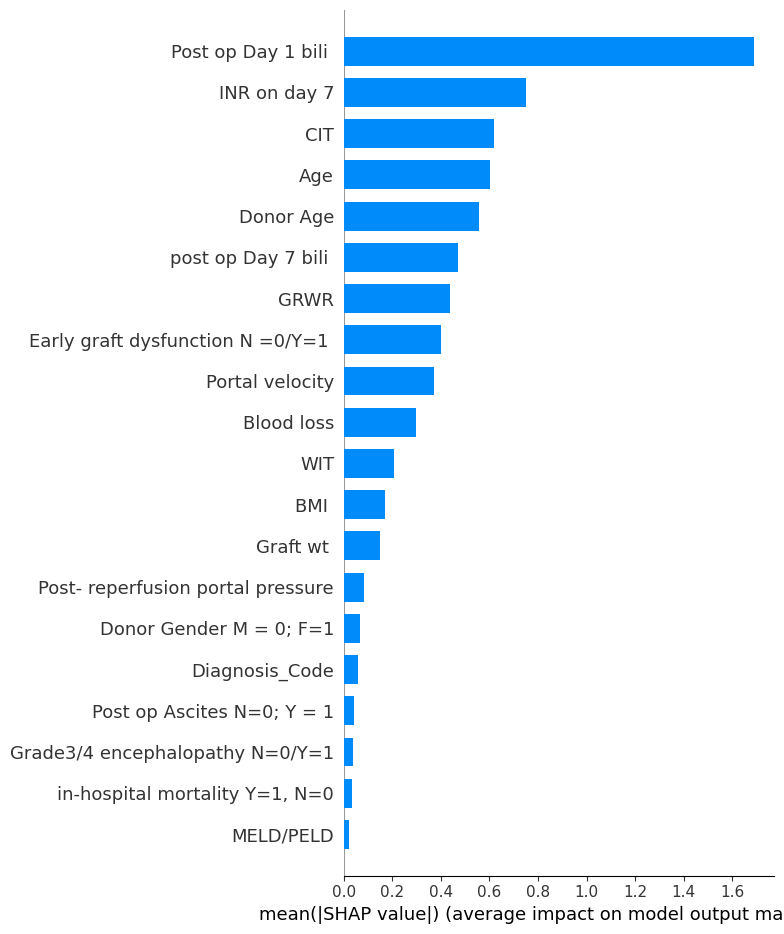

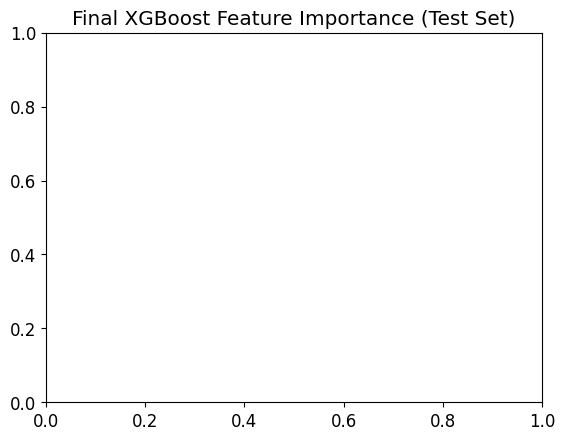

In [96]:
# %% [code] - Data Splitting with Validation Set
# Split into train (70%), validation (15%), test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=42
)

# Scaling with validation set
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# %% [code] - Enhanced Model Evaluation with Validation
def evaluate_model(model, X_train, y_train, X_val, X_test):
    """Train model and return validation/test metrics"""
    # Train with SMOTE only on training data
    pipeline = make_pipeline(
        SMOTE(random_state=42),
        model
    )
    pipeline.fit(X_train, y_train)
    
    # Threshold optimization using validation set
    best_thresh = optimize_threshold(pipeline, X_val, y_val)
    
    # Predictions
    val_proba = pipeline.predict_proba(X_val)[:, 1]
    test_proba = pipeline.predict_proba(X_test)[:, 1]
    
    val_pred = (val_proba >= best_thresh).astype(int)
    test_pred = (test_proba >= best_thresh).astype(int)
    
    return {
        'Validation Accuracy': accuracy_score(y_val, val_pred),
        'Validation F1': f1_score(y_val, val_pred),
        'Validation ROC AUC': roc_auc_score(y_val, val_proba),
        'Test Accuracy': accuracy_score(y_test, test_pred),
        'Test F1': f1_score(y_test, test_pred),
        'Test ROC AUC': roc_auc_score(y_test, test_proba),
        'Optimal Threshold': best_thresh
    }

# %% [code] - Model Configuration with Class Weights
models = [
    ('Logistic Regression', LogisticRegression(
        class_weight='balanced', 
        random_state=42,
        max_iter=1000
    )),
    ('Random Forest', RandomForestClassifier(
        class_weight='balanced',
        random_state=42
    )),
    ('XGBoost', XGBClassifier(
        scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
        eval_metric='logloss',
        random_state=42
    )),
    ('SVM', SVC(
        class_weight='balanced',
        probability=True,
        random_state=42
    ))
]

# %% [code] - Comprehensive Evaluation
results = []
for name, model in models:
    metrics = evaluate_model(model, X_train_scaled, y_train, X_val_scaled, X_test_scaled)
    metrics['Model'] = name
    results.append(metrics)
    
results_df = pd.DataFrame(results).round(3)
cols_order = ['Model', 'Validation Accuracy', 'Test Accuracy', 
              'Validation F1', 'Test F1', 'Validation ROC AUC', 
              'Test ROC AUC', 'Optimal Threshold']
print("\nFinal Model Performance:")
display(results_df[cols_order])

# %% [code] - Feature Stability Analysis
def check_feature_stability(models, feature_names):
    """Analyze feature importance consistency across train/val/test"""
    stability_scores = []
    
    for name, model in models:
        # Train on full training set
        model.fit(X_train_scaled, y_train)
        
        # Get importances
        if hasattr(model, 'feature_importances_'):
            train_imp = model.feature_importances_
            
            # Calculate validation importance using permutation
            val_imp = permutation_importance(
                model, X_val_scaled, y_val,
                n_repeats=10,
                random_state=42
            ).importances_mean
            
            # Stability score (cosine similarity)
            stability = np.dot(train_imp, val_imp) / (
                np.linalg.norm(train_imp) * np.linalg.norm(val_imp)
            )
            
            stability_scores.append({
                'Model': name,
                'Stability Score': round(stability, 3)
            })
            
    return pd.DataFrame(stability_scores)

print("\nFeature Stability Analysis:")
display(check_feature_stability(models, feature_names))

# %% [code] - Final SHAP Analysis on Test Set
# Best performing model (XGBoost)
xgb_model = XGBClassifier(
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    random_state=42
).fit(X_train_scaled, y_train)

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)

plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_scaled, 
                 feature_names=feature_names,
                 plot_type='bar')
plt.title('Final XGBoost Feature Importance (Test Set)')
plt.show()